In [1]:
%config InlineBackend.figure_format = 'retina' # For mac users with Retina display
import yaml
import pymc3 as pm
import math
import arviz as az
import theano
import theano.tensor as tensor
import pandas as pd
from matplotlib import rc
from scipy import optimize
import corner as crn
import seaborn as sns
import pickle 
from matplotlib.ticker import AutoMinorLocator
import matplotlib.patches as mpl_patches
import pygtc
######
import sys
sys.path.append('../HelpherFunctions/')
from Chi2Allvar import *
######
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"
plt.rcParams['font.family'] = 'serf'
filename ="../results/data.yaml"
########
stream = open(filename, 'r')#
data = yaml.safe_load(stream)
#
colpastil = ['#9cadce','#937eba','#f09494','#72bbd0','#52b2cf','#ffafcc','#d3ab9e' ]
NBINS = 100
LambdaNP2 = 1e+3**2
v4 = 246.**4
v3 = 246.**3
mh2 = 125.1**2
sqrt_2 = np.sqrt(2.0)
def mode(x):
    """ Finds the mode of x
        argument:
            x: an array
    """
    n, bins = np.histogram(x, bins=101)
    m = np.argmax(n)
    m = (bins[m] + bins[m-1])/2.
    return m

def multimode(x, n, hdi_prob):
    """ Finds all the modes in the distribution
        arguments:
            x: the array for the distribution
            n: the identifier for the variable
    """
    md = az.hdi(x, hdi_prob=hdi_prob, multimodal=False)
    if len(md) < 2 and n > 1:
        return np.NaN
    else:
        return md[n%2]
    
def mode(x):
    # Function to find mode of an array x
    n, bins = np.histogram(x, bins=101)
    m = np.argmax(n)
    m = (bins[m] + bins[m-1])/2.
    return m

def minimize(likelihood, guess):
    """ Minimizing routine for finding global mode
    argument:
        likelihood: the likelihood function
        guess: the guess for the mode, [r, theta]
    """
    res = optimize.minimize(lambda x: -likelihood(x[0], x[1]), guess, method='BFGS', tol=1e-6)
    return res
unity = lambda x : x


def runMCMC1param(likelihood, limits, trace_dir='', config=[], fit=True):
    """ pyMC3 MCMC run
        argument:
            likelihood: the likelihood function
            limits: an array of the limits for the parameters [r_lowers, r_upper, theta_lower, theta_upper]
            trace_dir: the directory to which the MCMC traces are saves. '' implies none
            config: the setup for the MCMC. [MCMC smaple size, target_accept, chains]
            fit: bolean for determining whether to run the fit
        returns:
            trace: if fit is true it returns the trace
            model;if fit is false it returns the model
    """
    with pm.Model() as model:
        k1 = pm.Uniform('k1', lower=limits[0], upper=limits[1])
        like = pm.Potential('like', likelihood(k1))
        
    if fit:
        with model:
            trace = pm.sample(config[0], tune=int(np.max([1000,config[0]/5])), cores=4, target_accept=config[1], chains=config[2], init='advi_map')
#             print(az.summary(trace, round_to=5)) # Turn on to print summary
            if trace_dir != '': pm.save_trace(trace=trace, directory=trace_dir, overwrite=True)
        return trace, model
    return model

In [4]:
def plotdist(data,filename, limit):
    stats_func_2 = {
        'b0': lambda x: multimode(x, 0, 0.9545),
        'b1': lambda x: multimode(x, 1, 0.9545),
        }
    var = ['k1']
    tr =data.get_values('k1', burn=100, combine=True)
    colpastil = ['#9cadce','#937eba','#f09494','#72bbd0', '#ffcaaf' ,'#ffafcc','#d3ab9e' ]
    #fig, ax = plt.subplots(1, figsize=(8, 8))
    df_2 = pd.DataFrame(az.summary(data, kind='stats', hdi_prob=0.9545, round_to='none', stat_funcs=stats_func_2))
    xup=df_2.loc['k1']['hdi_97.725%']
    xmu=[df_2.loc['k1']['mean']]
    xdown=df_2.loc['k1']['hdi_2.275%']
    print(xup)
    print(xmu)
    print(xdown)


    #az.plot_posterior(data, var_names=['k1'], hdi_prob=.95,color=colpastil[2],ax=ax)
    #az.plot_posterior(data, var_names=['k1'], hdi_prob=.95)
    GTC = pygtc.plotGTC(chains=np.array([tr]).T,
                    paramNames=r'$C_\phi$',
                    chainLabels=[''],
                    truths=[0.],
               #     priors=xmu,
                    truthLabels='',
                    colorsOrder=['blues_old'],
                    figureSize='APJ_page',
                    doOnly1dPlot=True,
                    filledPlots=False)

    for ax in GTC.get_axes():
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(axis='y', which='both', direction='in')
        ax.tick_params(axis='x',  which='both',direction='in')
        ax.tick_params(axis='y', which='minor', top=True, size= 5)
        ax.tick_params(axis='x',  which='minor',right=True,size= 5)
        ax.tick_params(axis='y', which='major', labelsize=26, rotation=0,top=True,size=10 )
        ax.tick_params(axis='x',  which='major',labelsize=26, rotation=0,right=True,size=10 )
    ax =GTC.get_axes()
    ax[0].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off)
      )
    ax[0].tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=True,         # ticks along the top edge are off)
         ) 
    ax[0].set_xlabel(r"$C_\phi\,[\mathrm{TeV}^{-2}]$",fontsize= 28)
    ax[0].set_ylabel(r"Posterior",fontsize= 28)
    ax[0].axvspan(xup,xdown, alpha=0.2, color='gray',label=r'95\% CI')   
    #plt.text(-0.2,50,text,fontsize=24)
   #plt.xlim(limits[0],limits[1])
    #plt.ylim(limits[2],limits[3])
    plt.tight_layout()
    GTC.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

Got error No model on context stack. trying to find log_likelihood in translation.
No handles with labels found to put in legend.


3.977752798247379
[-5.431096474870537]
-14.867033594472119


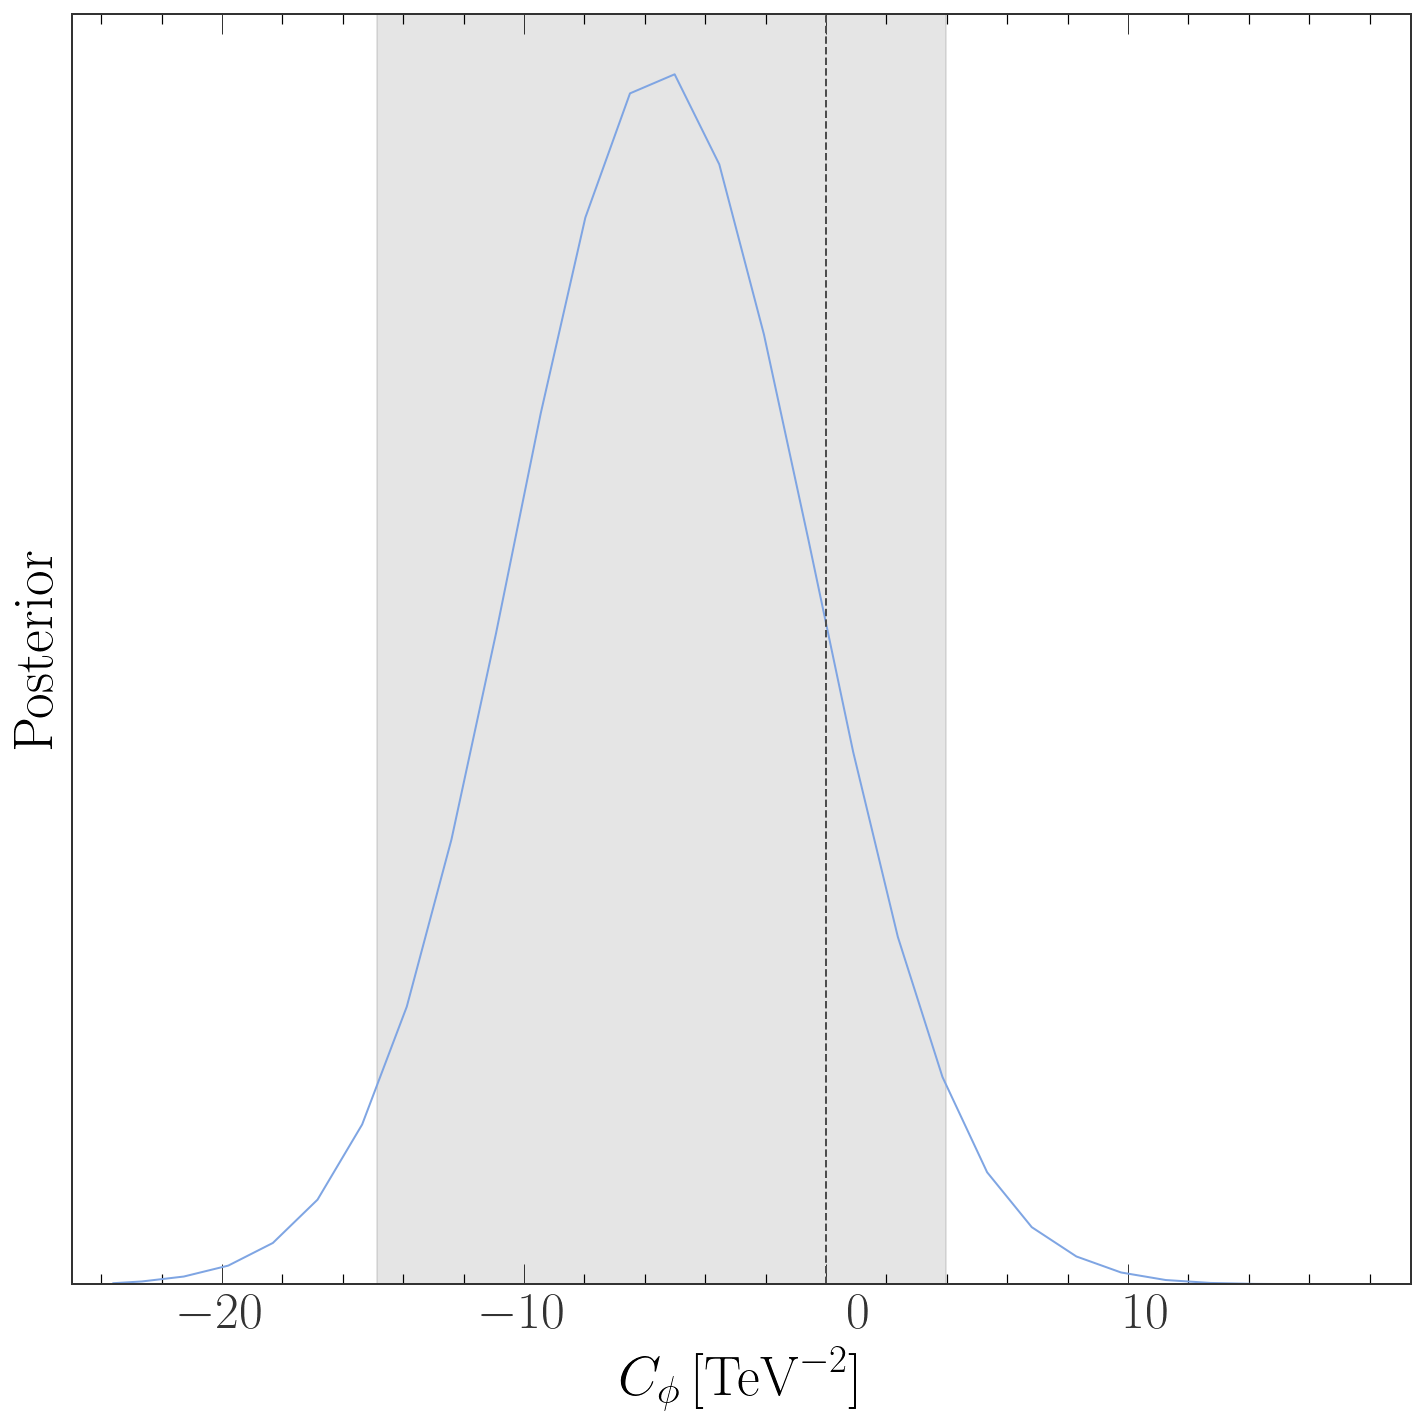

In [5]:
llCqtm =lambda CH :mylikelihoodAV(0.0,0.0,0.0,0.0,CH,data,experiments=['ATLAS','CMS'],
                                                                         HiggsChannels=['ggf','vbf','ttxh','vh','zh','wh']
                                                                           ,TopChannels=None, l3mode='linear',linearmu=True)
limits = [-40, 40]
config = [15000, 0.8, 5]
#inputarr = [np.array([samples1[:,4]]).T,
 #           np.array([samples2[:,4]]).T]
#print(tr)
#trace_1, model_1 = runMCMC1param(llCqtm, limits, config=config)

plotdist(trace_1,'./test.pdf', limits)


Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 1900
Interrupted at 1,899 [0%]: Average Loss = 13.69
Multiprocess sampling (50 chains in 4 jobs)
NUTS: [k1]


Sampling 50 chains for 1_000 tune and 1_500 draw iterations (50_000 + 75_000 draws total) took 28 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
No handles with labels found to put in legend.


3.548758760911256
[-5.6244568021320696]
-15.465410002102406


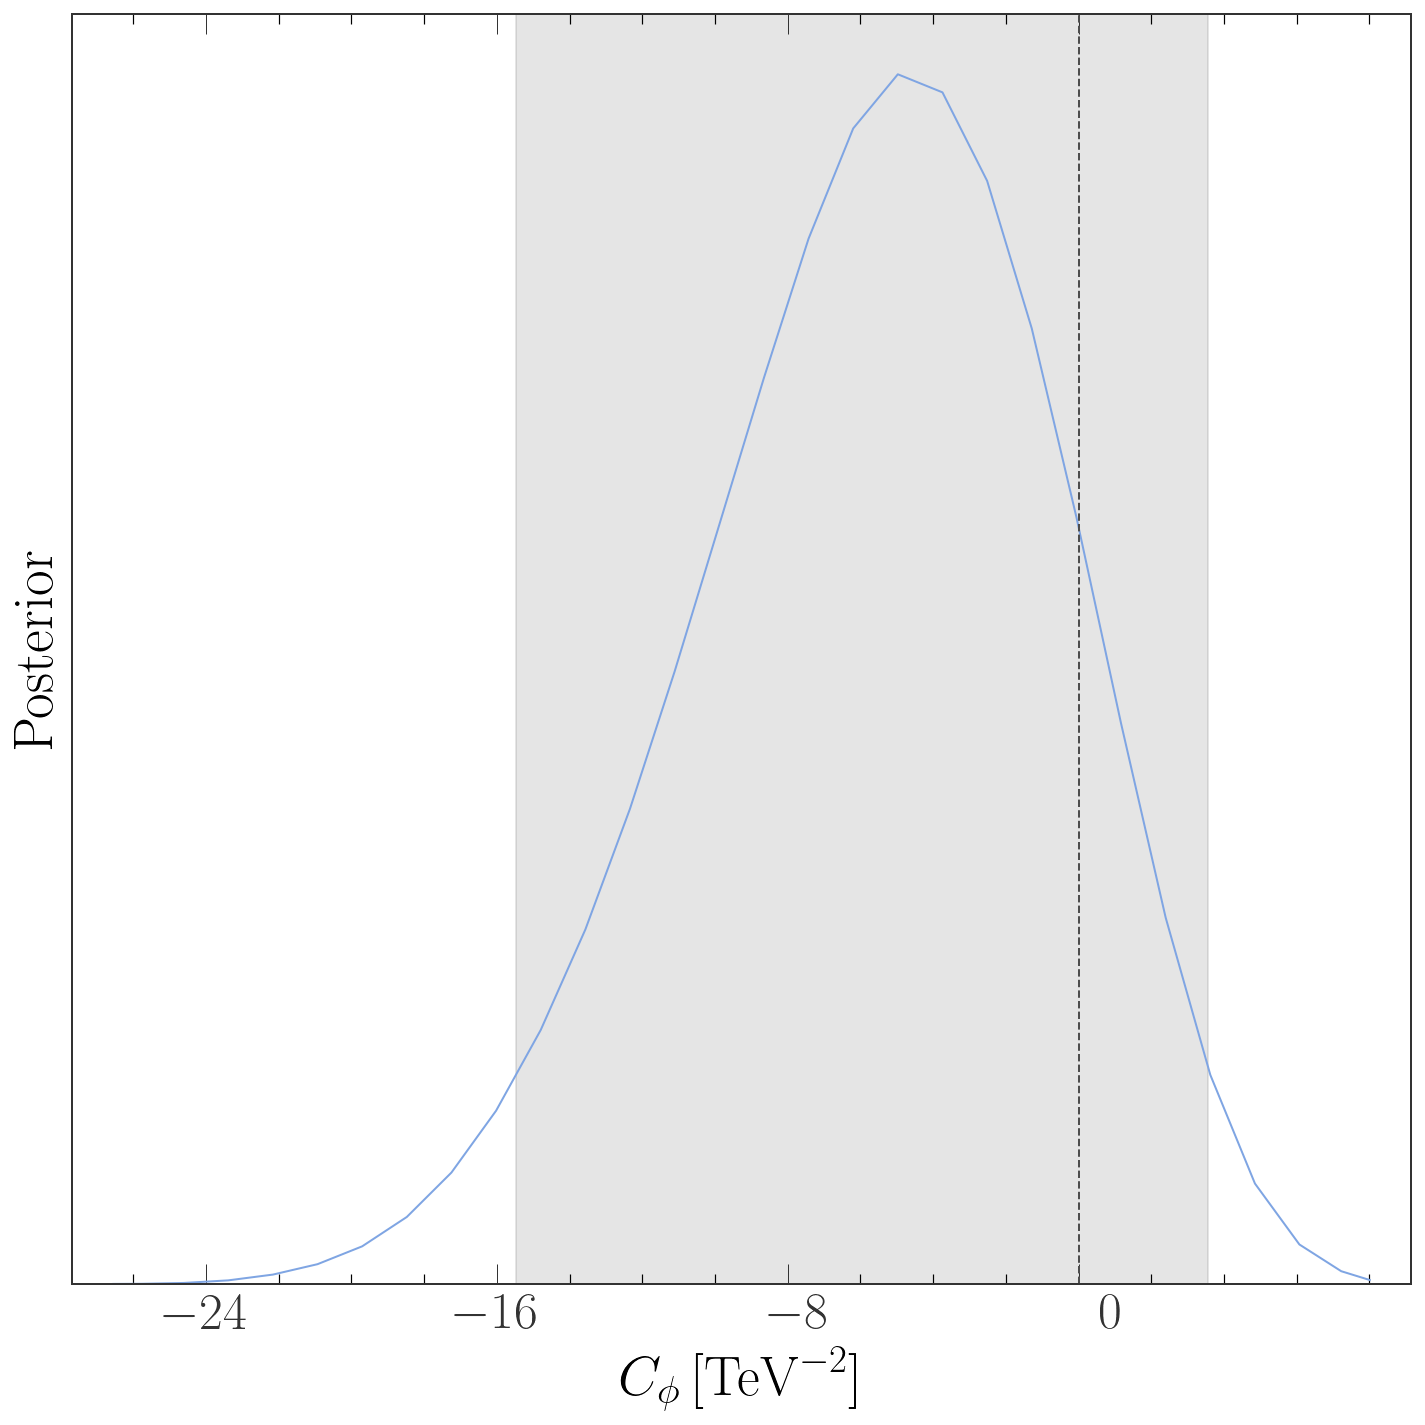

In [9]:
llCqtm =lambda CH :mylikelihoodAV(0.0,0.0,0.0,0.0,CH,data,experiments=['ATLAS','CMS'],
                                                                           HiggsChannels=['ggf','vbf','ttxh','vh','zh','wh']
                                                                           ,TopChannels=None, l3mode='resummed',linearmu=True)
limits = [-30, 30]
config = [1500, 0.8, 50]
trace_1, model_1 = runMCMC1param(llCqtm, limits, config=config)
plotdist(trace_1,'./nonlinearl3-hllhc.pdf', limits)